In [14]:
# Import packages
import os
import pickle

import imageio
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import motile
import networkx as nx
import numpy as np
import pandas as pd
import pymeshfix
import scipy
import seaborn as sns
import skimage
import zarr
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from matplotlib.colors import LightSource
from motile.plot import draw_solution, draw_track_graph
from skimage.io import imread, imsave
from skimage.measure import marching_cubes, regionprops_table
from skimage.transform import rescale
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from trimesh import Trimesh
from trimesh.smoothing import filter_taubin

In [6]:
import numpy as np
import pandas as pd

In [7]:
def extract_region_props(t, label_props, zarr_level):
    props = regionprops_table(
        channel_movie[str(t)]["labels"][label_props][zarr_level][:],
        properties=("label", "centroid"),
    )
    props["time_point"] = t
    return props

In [8]:
positions = [2, 11, 13]
# positions=[2]
conditions = ["Matrigel", "Agarose", "No Matrix"]

In [ ]:
# load graphs
tracking_df_cells = pd.DataFrame()
for position, condition in zip(positions, conditions):
    zarr_level = 0
    channel = "GFP"
    label = "cell_segmentation"
    track_path = f"/cluster/project/treutlein/DATA/imaging/viventis/Morphodynamics_of_human_early_brain_organoid_development/tracking/cell_tracking/tracks_distance_iou_max_dist_35/Position_{position}_Settings_1_Processed/"
    track_graph_cells = pickle.load(
        open(track_path + f"{channel}_{label}_track_motile_graph.pickle", "rb")
    )
    nx_track_graph_cells = pickle.load(
        open(track_path + f"{channel}_{label}_track.pickle", "rb")
    )

    # Load Zarr
    zarr_path = f"/cluster/project/treutlein/DATA/imaging/viventis/Morphodynamics_of_human_early_brain_organoid_development/tracking/cell_tracking/Position_{str(position)}_Settings_1_Processed_registered.zarr"
    zarr_array = zarr.open(zarr_path, mode="r")

    channel_movie = zarr_array[channel]

    label_props = "cell_segmentation_detection"

    # 1. Extract all xy coords + label names
    all_data_cell_list = Parallel(n_jobs=6, backend="multiprocessing", verbose=6)(
        delayed(extract_region_props)(t, label_props, zarr_level=zarr_level)
        for t in range(track_graph_cells.t_end)
    )

    all_data_cell = pd.DataFrame()
    for prop in tqdm(all_data_cell_list):
        all_data_cell = pd.concat([all_data_cell, pd.DataFrame(prop)])

    all_data_cell["centroid-0"] = all_data_cell["centroid-0"] * (
        2 / (0.347 * 2 ** (zarr_level + 1))
    )
    # Extract tracks
    roots = []
    for component in tqdm(nx.weakly_connected_components(nx_track_graph_cells)):
        G_sub = nx_track_graph_cells.subgraph(component)
        roots.extend([n for n, d in G_sub.in_degree() if d == 0])
    min_track_length = 5
    tracks = []
    for root in tqdm(roots):
        out_root_len_old = -1
        out_root_len_new = 1
        out_root = [root]
        while out_root_len_old != out_root_len_new:
            out_root_len_old = len(out_root)
            out_root = np.unique(out_root)
            out_root = list(nx_track_graph_cells.out_edges(out_root))
            out_root = np.unique(out_root)
            out_root_len_new = len(out_root)
        tracks.append(out_root)
    # Min length 15
    tracks = [track for track in tracks if len(track) > 15]
    unique_cells_tracks = np.unique(np.hstack(tracks))
    all_data_cell = all_data_cell[all_data_cell["label"].isin(unique_cells_tracks + 1)]

    # 2. Extract tracks
    all_data_cell["track"] = np.nan
    for track_num in tqdm(range(len(tracks))):
        all_data_cell.loc[
            all_data_cell["label"].isin(tracks[track_num] + 1), "track"
        ] = track_num

    all_data_cell = all_data_cell.sort_values(["track", "time_point"])

    velocity = np.zeros((len(all_data_cell),))
    directionality_all = np.zeros((len(all_data_cell),))
    directionality_all[:] = np.nan
    velocity[:] = np.nan
    min_dir_length = 5
    all_diffs = []
    for track_num in tqdm(np.unique(all_data_cell["track"])):
        track_coords = all_data_cell[all_data_cell["track"] == track_num][
            ["centroid-0", "centroid-1", "centroid-2"]
        ]
        diffs = track_coords.diff()
        distance = np.array(np.sqrt((diffs**2).sum(axis=1)))

        directionality = np.zeros(distance.shape)
        directionality[:] = np.nan
        for ind in range(min_dir_length, len(distance), 1):
            diffs_dir = (
                np.array(track_coords)[ind]
                - np.array(track_coords)[(ind - min_dir_length)]
            )
            distance_prev = np.sqrt((diffs_dir**2).sum())
            total_distance = distance[((ind + 1) - min_dir_length) : ind + 1].sum()
            directionality[ind] = distance_prev / total_distance

        distance[0] = np.nan

        velocity[all_data_cell["track"] == track_num] = distance
        directionality_all[all_data_cell["track"] == track_num] = directionality
        all_diffs.append(diffs)
    all_data_cell["velocity"] = velocity
    all_data_cell["directionality"] = directionality_all
    all_data_cell["dz"] = np.vstack(all_diffs)[:, 0]
    all_data_cell["dx"] = np.vstack(all_diffs)[:, 1]
    all_data_cell["dy"] = np.vstack(all_diffs)[:, 2]

    centroids = all_data_cell.loc[:, ["centroid-0", "centroid-1", "centroid-2"]]
    centroids["track"] = all_data_cell["track"]
    all_data_cell["centroid-0_smooth"] = np.array(
        centroids.groupby("track").rolling(10, min_periods=1).mean()["centroid-0"]
    )
    all_data_cell["centroid-1_smooth"] = np.array(
        centroids.groupby("track").rolling(10, min_periods=1).mean()["centroid-1"]
    )
    all_data_cell["centroid-2_smooth"] = np.array(
        centroids.groupby("track").rolling(10, min_periods=1).mean()["centroid-2"]
    )

    velocity = np.zeros((len(all_data_cell),))
    directionality_all = np.zeros((len(all_data_cell),))
    directionality_all[:] = np.nan
    velocity[:] = np.nan
    min_dir_length = 5
    all_diffs = []
    for track_num in tqdm(np.unique(all_data_cell["track"])):
        track_coords = all_data_cell[all_data_cell["track"] == track_num][
            ["centroid-0_smooth", "centroid-1_smooth", "centroid-2_smooth"]
        ]
        diffs = track_coords.diff()
        distance = np.array(np.sqrt((diffs**2).sum(axis=1)))

        directionality = np.zeros(distance.shape)
        directionality[:] = np.nan
        for ind in range(min_dir_length, len(distance), 1):
            diffs_dir = (
                np.array(track_coords)[ind]
                - np.array(track_coords)[(ind - min_dir_length)]
            )
            distance_prev = np.sqrt((diffs_dir**2).sum())
            total_distance = distance[((ind + 1) - min_dir_length) : ind + 1].sum()
            directionality[ind] = distance_prev / total_distance

        distance[0] = np.nan

        velocity[all_data_cell["track"] == track_num] = distance
        directionality_all[all_data_cell["track"] == track_num] = directionality
        all_diffs.append(diffs)
    all_data_cell["velocity_smooth"] = velocity
    all_data_cell["directionality_smooth"] = directionality_all
    all_data_cell["dz_smooth"] = np.vstack(all_diffs)[:, 0]
    all_data_cell["dx_smooth"] = np.vstack(all_diffs)[:, 1]
    all_data_cell["dy_smooth"] = np.vstack(all_diffs)[:, 2]

    all_data_cell["Day"] = (all_data_cell["time_point"] / 24) + 4
    all_data_cell.index = np.arange(len(all_data_cell))
    all_data_cell["Condition"] = condition
    all_data_cell["position"] = position

    tracking_df_cells = pd.concat([tracking_df_cells, all_data_cell])

tracking_df_cells.index = np.arange(len(tracking_df_cells))

In [9]:
import scipy

In [10]:
ind = 5

In [11]:
import seaborn as sns

sns.set_context("paper", rc={"font.size": 8, "axes.titlesize": 8, "axes.labelsize": 8})
rc = {
    "figure.figsize": (10, 5),
    "axes.facecolor": "white",
    "axes.grid": False,
    "grid.color": ".8",
    "font.size": 5,
}
plt.rcParams.update(rc)
cm = 1 / 2.54  # centimeters in inches
pallette = {"Matrigel": "#17ad97", "No Matrix": "#4d4d4d", "Agarose": "#98d9d1"}

In [ ]:
# tracking_df_cells.to_pickle("figures_csv/cell_tracks.pkl")

In [12]:
tracking_df_cells = pd.read_pickle("figures_csv/cell_tracks.pkl")

In [15]:
dpi = 100
zarr_level = 0
positions = [2, 11, 13]
conditions = ["Matrigel", "Agarose", "No Matrix"]
time_points = [24, 144]
directionality_center_df_all = pd.DataFrame()

for position, condition in tqdm(zip(positions, conditions)):
    for t in tqdm(time_points):

        # Calculate center of mass
        channel = "GFP"
        zarr_path = f"/cluster/project/treutlein/DATA/imaging/viventis/Morphodynamics_of_human_early_brain_organoid_development/tracking/cell_tracking/Position_{str(position)}_Settings_1_Processed_registered.zarr"
        zarr_array = zarr.open(zarr_path, mode="r")
        channel_movie = zarr_array[channel]

        back_range = 24
        cell_mask = channel_movie[t]["labels"]["cell_segmentation_detection"][0][:]
        cell_mask = rescale(
            cell_mask,
            [2 / (0.347 * 2), 1, 1],
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        )
        cell_mask = cell_mask > 0
        center_of_mass = scipy.ndimage.center_of_mass(cell_mask)

        # Get tracking position
        df_position = tracking_df_cells[tracking_df_cells["position"] == position]
        all_date_tp_low = df_position[
            (df_position["time_point"] <= t)
            & (df_position["time_point"] >= (t - back_range))
        ]

        # Calculate the directionality
        directionality_center_df = pd.DataFrame()
        for subtraj in all_date_tp_low.track.unique():
            temp = all_date_tp_low.loc[all_date_tp_low.track == subtraj].sort_values(
                "time_point"
            )
            if len(temp) > 1:
                if temp.iloc[-1]["time_point"] == t:
                    track_angles = pd.DataFrame(temp.iloc[-1]).T

                    start = temp.iloc[0][["centroid-1", "centroid-2", "centroid-0"]]
                    end = temp.iloc[-1][["centroid-1", "centroid-2", "centroid-0"]]
                    track_angles["dx_24"] = end[1] - start[1]
                    track_angles["dy_24"] = end[0] - start[0]
                    track_angles["dz_24"] = end[2] - start[2]
                    track_angles["track_length"] = len(temp)
                    directionality = np.array(
                        track_angles.iloc[0][
                            [
                                "dz_24",
                                "dy_24",
                                "dx_24",
                            ]
                        ]
                    )
                    centroids = np.array(
                        track_angles.iloc[0][["centroid-0", "centroid-1", "centroid-2"]]
                    )
                    vectors_to_centroids = centroids - center_of_mass
                    track_angles["Flow \n from the center"] = cosine_similarity(
                        [vectors_to_centroids], [directionality]
                    )[0][0]
                    directionality_center_df = pd.concat(
                        [directionality_center_df, track_angles]
                    )
        directionality_center_df_all = pd.concat(
            [directionality_center_df_all, directionality_center_df]
        )

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:49<00:00, 24.66s/it]
1it [00:49, 49.32s/it]
100%|██████████| 2/2 [00:30<00:00, 15.47s/it]
2it [01:20, 38.50s/it]
100%|██████████| 2/2 [00:29<00:00, 14.84s/it]
3it [01:49, 36.64s/it]


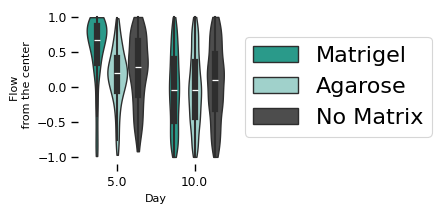

In [16]:
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
color_pallete_perturbation = {
    "Matrigel": "#17ad97",
    "No Matrix": "#4d4d4d",
    "Agarose": "#98d9d1",
}

fig, ax = plt.subplots(figsize=(2, 2))
sns.despine(left=True, bottom=True, right=True)

sns.violinplot(
    directionality_center_df_all,
    x="Day",
    y=f"Flow \n from the center",
    palette=color_pallete_perturbation,
    gap=0.05,
    hue="Condition",
    cut=0,
).legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=16)


# plt.savefig("figures_cell_tracking/flow_from_center.pdf", bbox_inches="tight")
# ax.set(ylim=(0, 10))

In [20]:
directionality_center_df_all[["Day", "Flow \n from the center", "Condition"]].to_csv(
    "figures_csv/fig_3_e_flow_from_center"
)

,Day,Flow \n from the center,Condition
24,5.0,0.937816,Matrigel
71,5.0,0.965808,Matrigel
102,5.0,0.974199,Matrigel
153,5.0,0.785908,Matrigel
227,5.0,0.888688,Matrigel
...,...,...,...
308615,10.0,0.664348,No Matrix
308647,10.0,-0.063809,No Matrix
308666,10.0,0.653936,No Matrix
308724,10.0,-0.248580,No Matrix


In [ ]:
# Color from north to south to east to west
n_quadrants = 20
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom",
    ["#c433c2", "green", "#fbff00", "#1bccc0", "#c433c2"],
    N=n_quadrants,
    gamma=1,
)
quadrant_colors = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

In [ ]:
##### generate data grid
N = 200
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
z = np.zeros((len(y), len(x)))  # make cartesian grid
for ii in range(len(y)):
    z[ii] = np.arctan2(y[ii], x)  # simple angular function

In [ ]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
# Create a custom colormap for xy directions
# xy_colors = ["green", "#c433c2", "#1bccc0", "#fbff00", "green"]
xy_colors = ["#c433c2", "green", "#fbff00", "#1bccc0", "#b133c4"]

n_bins = 20
cmap_xy_flow = mcolors.LinearSegmentedColormap.from_list("custom", xy_colors, N=n_bins)
quadrant_colors_flow = [mcolors.rgb2hex(cmap_xy_flow(i)) for i in range(cmap_xy_flow.N)]

n_bins = 20
# Reverse for quiver
reversed_colors = (
    list(reversed(quadrant_colors_flow))[-5:]
    + list(reversed(quadrant_colors_flow))[:-5]
)
cmap_xy_quiver = mcolors.LinearSegmentedColormap.from_list(
    "custom", reversed_colors, N=len(reversed_colors)
)
quadrant_colors_quiver = [
    mcolors.rgb2hex(cmap_xy_quiver(i)) for i in range(cmap_xy_quiver.N)
]
# Set arrow length (you can adjust this value)
arrow_length = 0.8

n_quadrants = n_bins
# Calculate angles for each arrow
angles = np.linspace(0, 2 * np.pi, n_quadrants, endpoint=False)

# Calculate arrow coordinates
X = np.zeros(n_quadrants)
Y = np.zeros(n_quadrants)
U = arrow_length * np.cos(angles)
V = arrow_length * np.sin(angles)

# Create the plot
plt.figure(figsize=(10, 10))
plt.axis("off")

# Plot the arrows
for i in range(n_quadrants):
    plt.quiver(
        X[i],
        Y[i],
        U[i],
        V[i],
        color=quadrant_colors_quiver[i],
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.025,
    )

# Set plot limits and labels
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.savefig(
    f"radial_quiver_plot.pdf",
    bbox_inches="tight",
    pad_inches=0,
)

In [ ]:
dpi = 100
zarr_level = 0

positions = [2, 11, 13]
conditions = ["Matrigel", "Agarose", "No Matrix"]
time_points = [24, 48, 120, 144]
for position, condition in zip(positions, conditions):
    for t in time_points:
        df_position = tracking_df_cells[tracking_df_cells["position"] == position]
        channel = "GFP"
        zarr_path = f"/cluster/project/treutlein/DATA/imaging/viventis/Morphodynamics_of_human_early_brain_organoid_development/tracking/cell_tracking/Position_{str(position)}_Settings_1_Processed_registered.zarr"
        zarr_array = zarr.open(zarr_path, mode="r")
        channel_movie = zarr_array[channel]

        back_range = 24
        image_t_shape = channel_movie[str(t)][zarr_level].shape
        image_t = channel_movie[str(t)][zarr_level][:]
        image_t = image_t.max(0)

        all_date_tp_low = df_position[
            (df_position["time_point"] <= t)
            & (df_position["time_point"] >= (t - back_range))
        ]

        # Create grids for streamplot
        all_u = []
        all_v = []
        all_w = []
        for time_point in np.unique(all_date_tp_low["time_point"])[1:]:
            all_date_tp_one = all_date_tp_low[
                (all_date_tp_low["time_point"] <= time_point)
                & (all_date_tp_low["time_point"] >= (time_point - 1))
            ]
            y, x = np.mgrid[: image_t_shape[1], : image_t_shape[2]]
            u = np.zeros_like(x)
            v = np.zeros_like(y)
            w = np.zeros_like(u)
            for subtraj in all_date_tp_low.track.unique():
                temp = all_date_tp_low.loc[
                    all_date_tp_low.track == subtraj
                ].sort_values("time_point")
                if len(temp) > 1:
                    if temp.iloc[-1]["time_point"] == t:
                        start = temp.iloc[0][["centroid-1", "centroid-2", "centroid-0"]]
                        end = temp.iloc[-1][["centroid-1", "centroid-2", "centroid-0"]]
                        dx, dy, dz = end - start
                        x_idx, y_idx = int(start[1]), int(start[0])
                        u[y_idx, x_idx] = dx
                        v[y_idx, x_idx] = dy
                        w[y_idx, x_idx] = dz
            all_u.append(u)
            all_v.append(v)
            all_w.append(w)

        u = np.mean(all_u, axis=0)
        v = np.mean(all_v, axis=0)
        w = np.mean(all_w, axis=0)

        u = skimage.filters.gaussian(u, 20)
        v = skimage.filters.gaussian(v, 20)
        w = skimage.filters.gaussian(w, 20)

        # Calculate the angle in the z-direction
        angles_z = np.arctan2(w, np.sqrt(u**2 + v**2))

        # Calculate the angle of the flow at each point
        angles_xy = np.arctan2(v, u)

        from matplotlib.colors import to_hex

        """
        # Color from north to south to east to west
        n_quadrants = 20
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "custom",
            ["#c433c2", "green", "#fbff00", "#1bccc0", "#b133c4"],
            N=n_quadrants,
            gamma=1,
        )
        quadrant_colors = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]
        """
        quadrant_colors = quadrant_colors_flow

        # N-bins from white to color to black
        n_bins = n_quadrants

        cmap_list = []
        for color in quadrant_colors:
            cmap_list.extend(
                mcolors.LinearSegmentedColormap.from_list(
                    "", ["white", color, "black"], N=n_bins
                )(np.linspace(0, 1, n_bins))
            )
        custom_cmap = mcolors.LinearSegmentedColormap.from_list(
            "custom",
            np.vstack([cmap_list[i::n_bins] for i in range(n_quadrants)]),
            N=len(cmap_list),
        )

        # Normalize angles_xy to [0, 1] for colormap
        norm_xy = mcolors.Normalize(vmin=-np.pi, vmax=np.pi)
        norm_z = mcolors.Normalize(vmin=-np.pi, vmax=np.pi)

        # Create a combined 2D array for color
        angles_xy_norm = norm_xy(angles_xy)
        angles_z_norm = norm_z(angles_z)
        color_array = np.zeros_like(angles_xy_norm, dtype=int)
        for i in tqdm(range(angles_xy_norm.shape[0])):
            for j in range(angles_xy_norm.shape[1]):
                quadrant = int(np.round(((n_quadrants - 1) * angles_xy_norm[i, j])))
                z_value = int(np.round(((n_bins - 1) * angles_z_norm[i, j])))
                color_array[i, j] = (quadrant) + (z_value * (n_bins))
        norm = mcolors.Normalize(vmin=0, vmax=n_bins * n_quadrants - 1)

        fig = plt.figure(figsize=(image_t.shape[0] / dpi, image_t.shape[1] / dpi))
        fig.tight_layout()

        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis("off")
        ax.imshow(np.ones((image_t.shape) + (3,)) * 255)

        # Normalize the color array
        norm = mcolors.Normalize(vmin=0, vmax=n_bins * n_quadrants - 1)
        # Create streamplot with the new color scheme
        stream = ax.streamplot(
            x,
            y,
            v,
            u,
            color=color_array,
            cmap=custom_cmap,
            norm=norm,
            density=2,
            linewidth=4,
            arrowsize=2,
            arrowstyle="-|>",
        )
        plt.savefig(
            f"figures_cell_tracking/cell_tracks/stream_plot_day_{4+int((t)/24)}_condition_{condition}.svg",
            bbox_inches="tight",
            pad_inches=0,
        )

        image_t = channel_movie[str(t)][zarr_level][:]
        image_t = image_t.max(0)
        all_date_tp_low = df_position[
            (df_position["time_point"] <= t)
            & (df_position["time_point"] >= (t - back_range))
        ]

        # Create lists to store arrow start points, vectors, and angles
        X, Y, U, V, W, angles, xz_angles = [], [], [], [], [], [], []

        # Populate lists with arrow data
        for subtraj in all_date_tp_low.track.unique():
            temp = all_date_tp_low.loc[all_date_tp_low.track == subtraj].sort_values(
                "time_point"
            )
            if len(temp) > 1:
                if temp.iloc[-1]["time_point"] == t:
                    start = temp.iloc[0][["centroid-1", "centroid-2", "centroid-0"]]
                    end = temp.iloc[-1][["centroid-1", "centroid-2", "centroid-0"]]
                    X.append(start[1])
                    Y.append(start[0])
                    dx = end[1] - start[1]
                    dy = end[0] - start[0]
                    dz = end[2] - start[2]
                    U.append(dx)
                    V.append(dy)
                    W.append(dz)
            # if np.arctan2(dz, dx)!=np.arctan2(dz, dy):
            # print("wrong")
            # break

        # Convert lists to numpy arrays
        X, Y, U, V, W = map(np.array, [X, Y, U, V, W])
        xy_angles = np.arctan2(V, U)
        z_angles = np.arctan2(W, np.sqrt(U**2 + V**2))
        """
        # Create a custom colormap for xy directions
        xy_colors = ["green", "#c433c2", "#1bccc0", "#fbff00", "green"]

        # xy_colors = ["#c433c2", "green", "#dde014", "#1bccc0","#c433c2"]
        n_bins = 20
        cmap_xy = mcolors.LinearSegmentedColormap.from_list(
            "custom", xy_colors, N=n_bins
        )
        quadrant_colors = [mcolors.rgb2hex(cmap_xy(i)) for i in range(cmap_xy.N)]
        """
        quadrant_colors = quadrant_colors_quiver

        cmap_list = []

        for color in quadrant_colors:
            cmap_list.extend(
                mcolors.LinearSegmentedColormap.from_list(
                    "", ["white", color, "black"], N=n_bins
                )(np.linspace(0, 1, n_bins))
            )

        custom_cmap = mcolors.LinearSegmentedColormap.from_list(
            "custom",
            np.vstack([cmap_list[i::n_bins] for i in range(n_bins)]),
            N=len(cmap_list),
        )

        norm_xy = mcolors.Normalize(vmin=-np.pi, vmax=np.pi)
        norm_z = mcolors.Normalize(vmin=-np.pi, vmax=np.pi)

        # Create a combined 2D array for color
        angles_xy_norm = norm_xy(xy_angles)
        angles_z_norm = norm_z(z_angles)

        colors = []
        for xy_angle, xz_angle in zip(angles_xy_norm, angles_z_norm):
            quadrant = int(np.round(((n_bins - 1) * xy_angle)))
            z_value = int(np.round(((n_bins - 1) * xz_angle)))
            colors.append(custom_cmap((quadrant) + (z_value * (n_bins))))

        color = np.array(colors)

        fig = plt.figure(
            figsize=(image_t.shape[0] / dpi, image_t.shape[1] / dpi), frameon=False
        )
        fig.tight_layout()
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis("off")
        # ax.imshow(image_t, cmap="gray")
        ax.imshow(np.ones((image_t.shape) + (3,)) * 255)

        # colors = np.array([cmap_xy(norm(xy_angle)) for xy_angle in angles])

        # Create quiver plot with color based on direction
        quiver = ax.quiver(
            X,
            Y,
            U,
            V,
            color=colors,
            scale=1.0,
            scale_units="xy",
            angles="xy",
            width=0.005,
            headwidth=3,
            headlength=4,
        )

        # Add a colorbar
        # cbar = plt.colorbar(quiver, ax=ax, orientation='vertical', pad=0.05)
        # cbar.set_label('Direction')
        # cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        # cbar.set_ticklabels(['W', 'S', 'E', 'N', 'W'])

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)

        plt.savefig(
            f"figures_cell_tracking/cell_tracks/track_plot_day_{4+int((t)/24)}_condition_{condition}.svg",
            bbox_inches="tight",
            pad_inches=0,
        )